In [3]:
pwd

'/Users/ulukbek_attokurov/Documents/recommender/recommenders/notebooks'

In [4]:
cd ..

/Users/ulukbek_attokurov/Documents/recommender/recommenders


### Data Understanding

In [25]:
# import libraries 

import pandas as pd 
from pathlib import Path 
from utils.readers import CSVReader



In [26]:
# data reading 

dirname = Path("data") 

file_name = Path("events.csv") 

file_path = dirname / file_name

events = CSVReader.read(str(file_path))

In [27]:
events.shape

(2756101, 5)

In [28]:
events.head(2)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN


### Description of the columns 

- timestamp : event time 
- visitorid : user id  
- event : event type 
- itemid: product id  
- transaction_id : transaction id 

### Quality check 

In [29]:
# check timestamps 

dates = pd.to_datetime(events['timestamp'], unit = 'ms')

In [30]:
# it is stated in the data cart that the dataset contains events for 4.5 months 
# as it can be seen here we can validate them using proper datetime and thus we can convert into datetime format from unixtimestamp 
dates.min(), dates.max()

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

In [31]:
events['dt'] = pd.to_datetime(events['timestamp'], unit = 'ms')

In [32]:
# missing values 
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dt                     0
dtype: int64

In [34]:
events.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [39]:
# transaction ids are not null in transaction events and their counts match which is expected behavior 
events[events.event == "transaction"].transactionid.notnull().sum() == (events.shape[0] -  events.transactionid.isnull().sum())

np.True_

### Univariate Statistics 

In [46]:
# unique visitors and unique products  


unique_visitors = events.visitorid.nunique()

unique_products = events.itemid.nunique()

print(f"# of unique visitors {unique_visitors} and # of unique products {unique_products}")

# of unique visitors 1407580 and # of unique products 235061


In [48]:
# event distributions 

event_distributions  =  events.event.value_counts()

Matplotlib is building the font cache; this may take a moment.


<Axes: ylabel='event'>

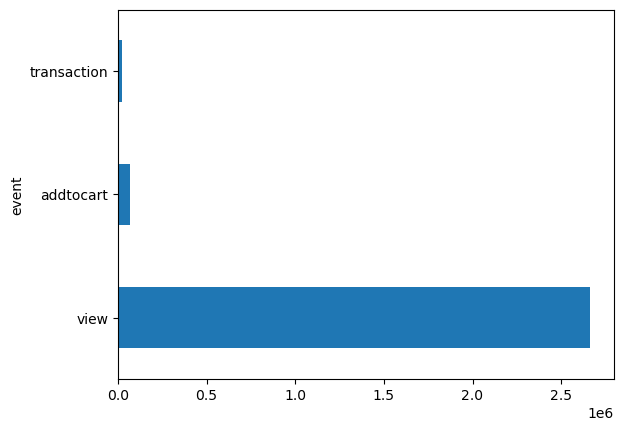

In [51]:
event_distributions.plot(kind = 'barh')

Events distributions has expected behaviour: view events are prevalent and transaction events are rare, sparse. 

### Bivariate statistics 

In [52]:
# general statistics 

events_per_visitor = events.groupby("visitorid")['event'].count()

In [64]:
# events per day : to detect bots , they can create noisy events 

event_stats = events_per_visitor.value_counts() / unique_visitors 

It seems that more than 70% of visitors generate one event ! 

In [66]:
event_stats

event
1       7.115475e-01
2       1.463448e-01
3       5.655949e-02
4       2.756220e-02
5       1.631666e-02
            ...     
178     7.104392e-07
1614    7.104392e-07
726     7.104392e-07
463     7.104392e-07
469     7.104392e-07
Name: count, Length: 343, dtype: float64

In [73]:
event_stats = event_stats.reset_index()

In [76]:
expected_event_per_visitor = (event_stats['event'] * event_stats['count']).sum()

In [77]:
print(f"Expected number of events per visitor : {expected_event_per_visitor}")

Expected number of events per visitor : 1.9580421716705267


In [155]:
# visitor distributions per event type 


view_visitors = events[events.event == 'view'].visitorid.unique() 

addtocart_visitors = events[events.event == 'addtocart'].visitorid.unique() 

transaction_visitors = events[events.event == 'transaction'].visitorid.unique() 

In [84]:
# general CR in terms of addtocart and transactions 

number_of_addtocart_visitors = len(addtocart_visitors) 

number_of_transaction_visitors = len(transaction_visitors) 

number_of_view_visitors = len(view_visitors)

CR_addtocart = number_of_addtocart_visitors / number_of_view_visitors

CR_transaction = number_of_transaction_visitors / number_of_view_visitors 

bounce_rate = number_of_transaction_visitors / number_of_addtocart_visitors 

In [86]:
print(f"""Number of vistors (view) : {number_of_view_visitors} \n 
          Number of visitors (addtocart) : {number_of_addtocart_visitors} \n 

          Number of visitors (transactions) : {number_of_transaction_visitors}


""")

Number of vistors (view) : 1404179 
 
          Number of visitors (addtocart) : 37722 
 

          Number of visitors (transactions) : 11719





In [87]:
print(f"CR(Add to cart) : {CR_addtocart} , \n CR(transaction) : {CR_transaction} \n bounce rate : {1- bounce_rate}")

CR(Add to cart) : 0.026864096386571796 , 
 CR(transaction) : 0.008345802066545647 
 bounce rate : 0.6893324850220031


### General CR 

- add to cart rate is around 2% is lower taking into account the number of unique visitors and number of unique products. One of the most probable reasons might be one timers who visit the website by advertisement as the number of visitors with one event is high. They might click the product on social networks, search engines and redirected to the main website. However they are not making any purchase or any events on the website ! It might be caused by advertisements and campaigns ! 

- CR rate is very low as well: it should be increased using personalization techniques and proper advertising 

bounce rate (a visitor adding the product into the basket but not making purchase)  is very high (70%) ! it may sign that the users can not make selection among the huge number of options . In this case also proper personalization on product detail page and add to cart page should be handled! 

# CR in terms of unique visitor ids  

In [168]:
# import modules  

from utils.converters import convert_to_list
from utils.conversion import VisitorCR

In [157]:
# format visitors 

transaction_visitors = convert_to_list(transaction_visitors) 

addtocart_visitors = convert_to_list(addtocart_visitors) 

view_visitors = convert_to_list(view_visitors)

In [169]:
visitor_cr = VisitorCR(view_visitors, addtocart_visitors, transaction_visitors)

In [170]:
# conversion stats 

visitor_to_addtocart = visitor_cr.cr_visitors_to_addtocart()
visitors_to_purchae = visitor_cr.cr_visitors_to_purchase()
addtocart_to_purchase = visitor_cr.cr_addtocart_to_purchase()
neveractives = visitor_cr.visitors_only() / len(view_visitors)

In [171]:
print(f"""
    Visitors to Addtocart : {visitor_to_addtocart} 
    Visitors to Purchase: {visitors_to_purchae} 
    Addtocart to Purchase: {addtocart_to_purchase}
    NeverActives : {neveractives}


""" )


    Visitors to Addtocart : 0.024499013302435087 
    Visitors to Purchase: 0.008040997622098037 
    Addtocart to Purchase: 0.28036689465033665
    NeverActives : 0.9755009866975649





### Insights 

- 2% of visitors are engaged in terms of add to carts 
- 0.8% of visitors are converted to customers 
- 72% of visitors who added to basket not purchased (Cart Abandonment Rate is high) 
- 98% of visitors are never actives (never made any purchase)

Those statistics state that visitors are not engaged in the products and can not converted into customers ! 

Thus personalization strategies with recommendation engines should be employed to increase conversion rate and decrease Cart Abandonment Rate! 


### Product analytics

In [263]:
# wwhat is the event distribution of pproducts 

product_stats = events[['visitorid', 'itemid', 'event']].drop_duplicates().groupby("itemid")['event'].value_counts().unstack(1).fillna(0)

In [278]:
product_stats['traffic_distribution'] = product_stats.view / product_stats.view.sum()

Events are too sparse as it can be seen on the plot !

### Popular visited products

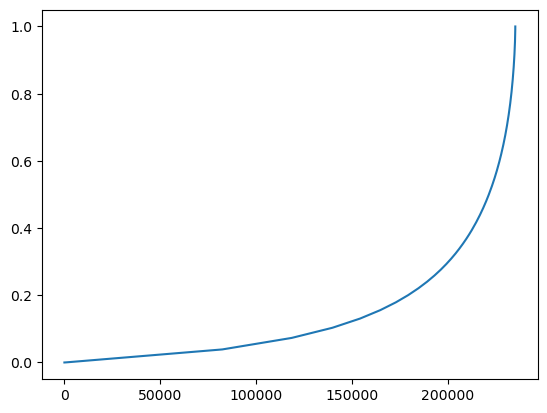

In [279]:
most_popular_products = product_stats.sort_values(ascending= True, by = 'view').traffic_distribution.reset_index(drop = True).cumsum().plot(kind = 'line')

As shown on the plot less number of products are dominating the traffic and we have to undersand which products are 

<Axes: >

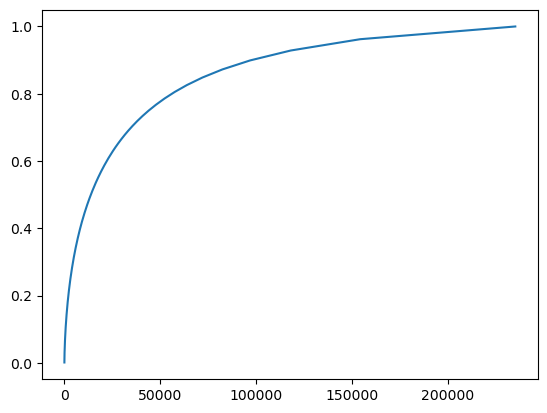

In [282]:
product_stats.sort_values(by = "traffic_distribution", ascending = False)['traffic_distribution'].cumsum().reset_index(drop = True).plot(kind = 'line')

First 100000 products are generating 85% of the traffic ! 

<Axes: xlabel='view'>

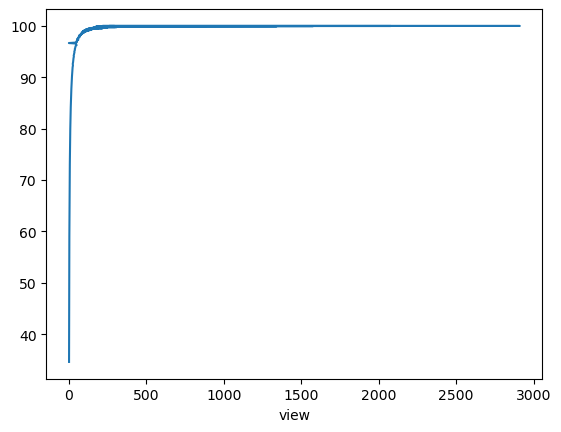

In [291]:
product_view_counts = product_stats.view.value_counts() / product_stats.shape[0] * 100


product_view_counts.cumsum().plot(kind = 'line')

35% of the product generating only one event which means they might cause noise in recommendations !

In [298]:
product_view_counts[:10].sum()

/var/folders/6_/4h_8_hc94y7cxqq2l4fcz6fm0000gn/T/ipykernel_1788/495054536.py:1: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead



np.float64(81.60222240184461)

80% of the products can have no more than 10 views !

# All of the stated stats means that we have sparse dataset in terms of views , purchase etc. !!! 

In [276]:
most_popular_products

<Axes: >

In [246]:
import matplotlib.pyplot as plt
product_visits = events.itemid.value_counts()

cumulative_sum = product_visits.reset_index(drop = True).cumsum()




In [252]:
product_visits.describe()

count    235061.000000
mean         11.725046
std          37.032101
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        3412.000000
Name: count, dtype: float64

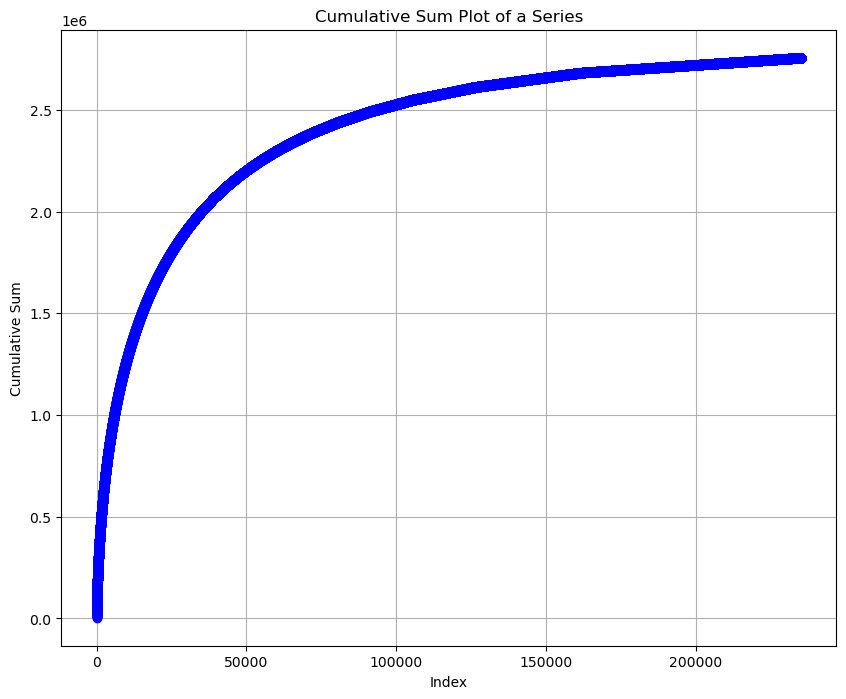

In [248]:

# Plot the cumulative sum

plt.figure(figsize = (10, 8))
cumulative_sum.plot(kind='line', marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.title("Cumulative Sum Plot of a Series")
plt.grid(True)
plt.show()

# let us have a look for statistics of customers with purchase distributions 




In [183]:
transaction_customer_count = events.groupby("visitorid")['itemid'].nunique().value_counts().reset_index()

In [186]:
transaction_customer_count.columns = ['number_of_products', "number_of_customers"]

In [206]:
transaction_customer_count['percentage_of_customers'] = transaction_customer_count['number_of_customers'] / events.visitorid.nunique()

In [209]:
# top 5 

top5 = transaction_customer_count.percentage_of_customers.iloc[: 5].sum()

top5

np.float64(0.9808287983631481)

98% of customers purchased maximum 5 unique products ! 

<Axes: xlabel='number_of_products', ylabel='percentage_of_customers'>

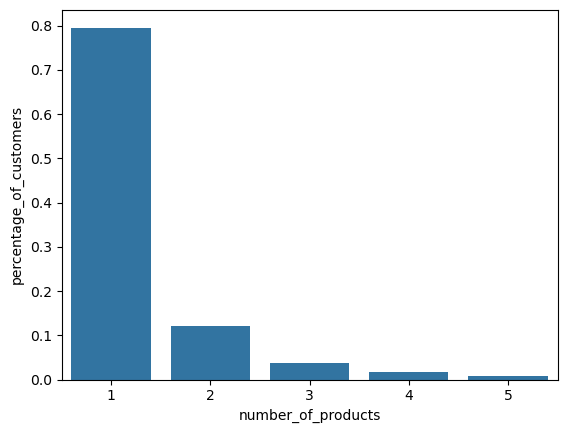

In [210]:
import seaborn as sns  


sns.barplot(transaction_customer_count.iloc[:5] , x = "number_of_products", y = "percentage_of_customers")

<Axes: xlabel='number_of_products', ylabel='percentage_of_customers'>

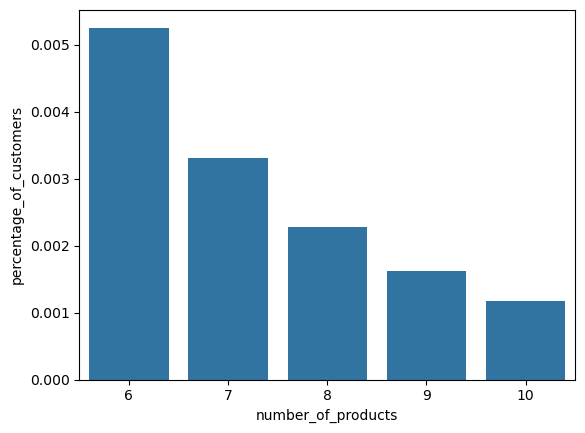

In [211]:
import seaborn as sns  


sns.barplot(transaction_customer_count.iloc[5: 10] , x = "number_of_products", y = "percentage_of_customers")

<Axes: xlabel='number_of_products', ylabel='percentage_of_customers'>

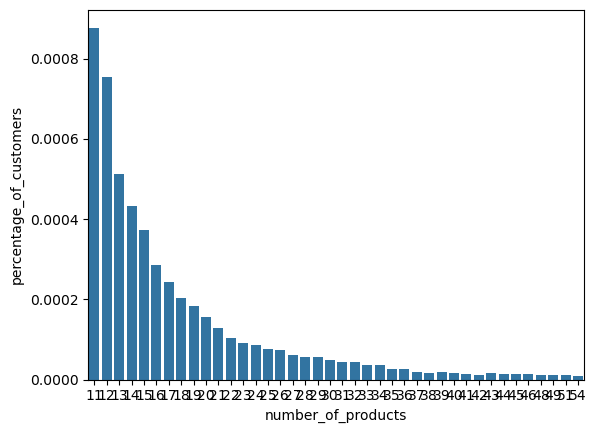

In [214]:
import seaborn as sns  


sns.barplot(transaction_customer_count.iloc[10: 50] , x = "number_of_products", y = "percentage_of_customers")

<Axes: xlabel='number_of_products', ylabel='percentage_of_customers'>

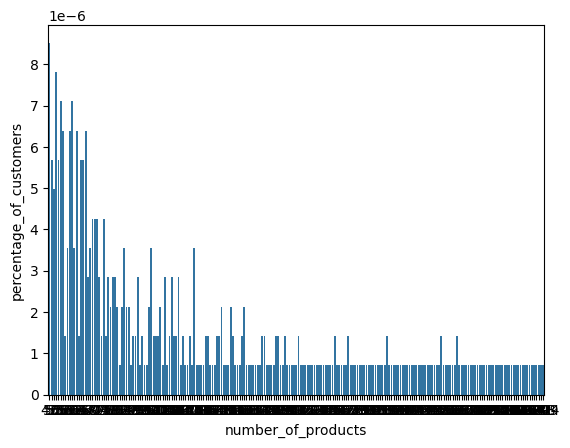

In [215]:
import seaborn as sns  


sns.barplot(transaction_customer_count.iloc[50:] , x = "number_of_products", y = "percentage_of_customers")

Customers with unique products purchased more than 20 can be eliminated from the 

In [225]:
transaction_customer_count[transaction_customer_count.number_of_products >= 10]

,number_of_products,number_of_customers,percentage_of_customers
9,10,1660,1.179329e-03
10,11,1235,8.773924e-04
11,12,1061,7.537760e-04
12,13,720,5.115162e-04
13,14,608,4.319470e-04
...,...,...,...
264,280,1,7.104392e-07
265,818,1,7.104392e-07
266,206,1,7.104392e-07
267,2209,1,7.104392e-07


# Transaction data seems to be very sparse: and thus we can consider view data in order to generate some recommendations . 